# Purpose

This notebook produces analyses on the dataset, including:
* HR and RR distribution as a function of age
* Distribution of PPG quality vs age
* Distribution of RR and age, as a function of PPG quality
* RR vs age distribution compared to literature values
* Histogram of PPG quality vs age
* Histogram of RR vs PPG quality
* Histogram of RR vs age

This notebook was derived from kapiolani_dataset_eda.ipynb. It has only been lightly updated, and
much of it does not work.


In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# df = pd.read_csv("../data/results/kapiolanip1_quality metric v3.120230913 114011_features.csv")
df = pd.read_csv("../data/results/capnobase_spontaneous breathing all ages PPG dynamic_20240807-173606_features.csv")

# re-define quality column based on latest definition
df=df.rename(columns={'quality - template matching-pct nonconforming pulses':'quality - template matching-pct diagnostic quality pulses'})
df['quality - template matching-pct diagnostic quality pulses'] = 1-df['quality - template matching-pct diagnostic quality pulses']

df['binned quality 25'] = pd.cut(df['quality - template matching-pct diagnostic quality pulses'], bins=25)
df['binned quality 10'] = pd.cut(df['quality - template matching-pct diagnostic quality pulses'], bins=10)
df.dropna(subset='RR ref co2', inplace=True)

In [21]:
def map_age_range(years):
    if years <= 3:
        return "0 to 3"
    elif 3 < years <= 5:
        return "3 to 5"
    elif 5 < years <= 9:
        return "5 to 9"
    elif 9 < years <= 12:
        return "9 to 12"
    elif 12 < years <= 18:
        return "12 to 18"
    elif 18 < years <= 100:
        return "18 to 100"
    else:
        return "unknown"
    
age_bracket_order = ["0 to 3","3 to 5","5 to 9","9 to 12","12 to 18","18 to 100","unknown"]
age_brackets = df['subject age'].apply(map_age_range)
df['age brackets'] = age_brackets

# HR and RR distributions

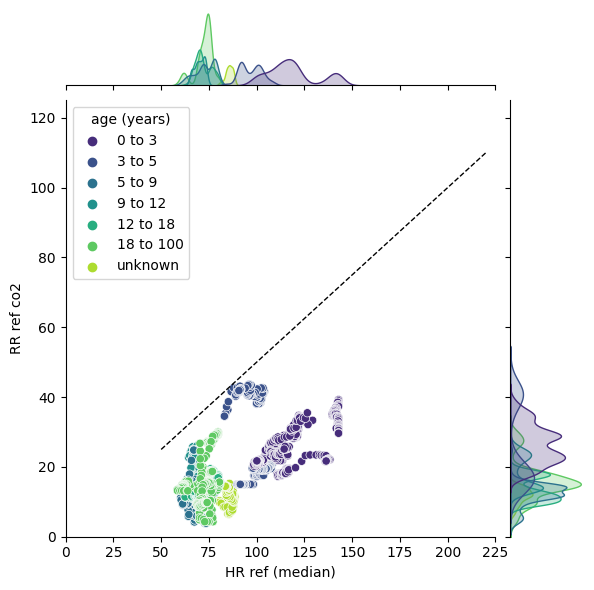

In [22]:
plot = sns.jointplot(
    data=df,
    x='HR ref (median)', 
    y='RR ref co2', 
    hue='age brackets', hue_order=age_bracket_order,
    palette='viridis'
    )
plot.ax_joint.legend(loc='center left')
plot.ax_joint.set_xlim(0, 225)
plot.ax_joint.set_ylim(0, 125)
plot.ax_joint.plot([50,220], [25,110], 'k--', linewidth = 1)
plot.ax_joint.legend(title="age (years)")

Text(0.5, 1.0, 'distribution of quality vs age brackets')

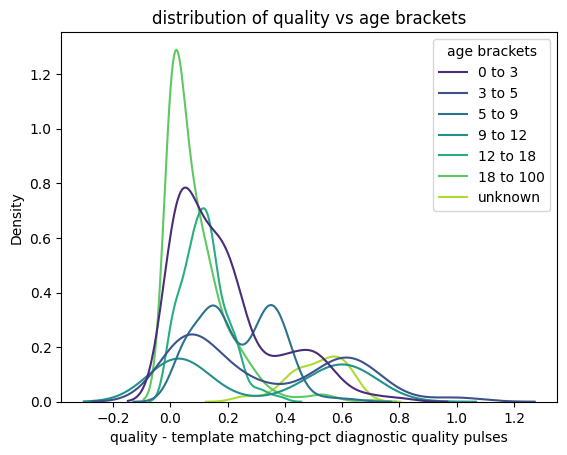

In [23]:
plot = sns.kdeplot(
    data=df, 
    x='quality - template matching-pct diagnostic quality pulses',
    hue='age brackets',
    hue_order=age_bracket_order,
    palette='viridis'
    )
plt.title('distribution of quality vs age brackets')

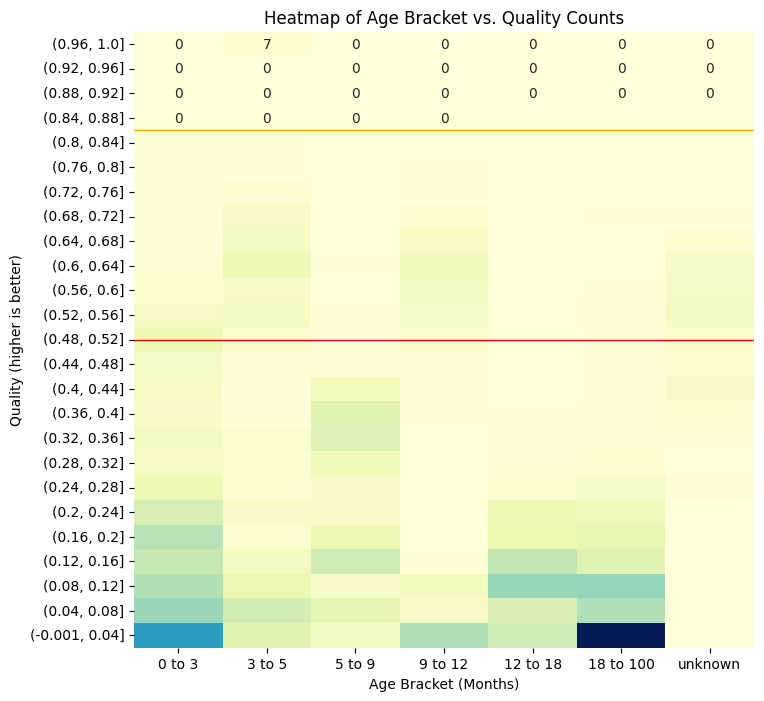

In [24]:
# bin the quality column and create a heatmap via groupby
num_bins=25
pivot_table = df.groupby([pd.cut(df['quality - template matching-pct diagnostic quality pulses'], num_bins), 'age brackets']).size().unstack(fill_value=0)
pivot_table = pivot_table[age_bracket_order]
pivot_table = pivot_table.iloc[::-1] # flip the table so that highest quality is on top

# Create the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d', cbar=False)
# Add an orange line between the 4th and 5th rows
plt.axhline(y=4, color='orange', linewidth=1)
plt.axhline(y=12.5, color='red', linewidth=1)

plt.title('Heatmap of Age Bracket vs. Quality Counts')
plt.xlabel('Age Bracket (Months)')
plt.ylabel('Quality (higher is better)')
plt.show()

(-5.0, 65.0)

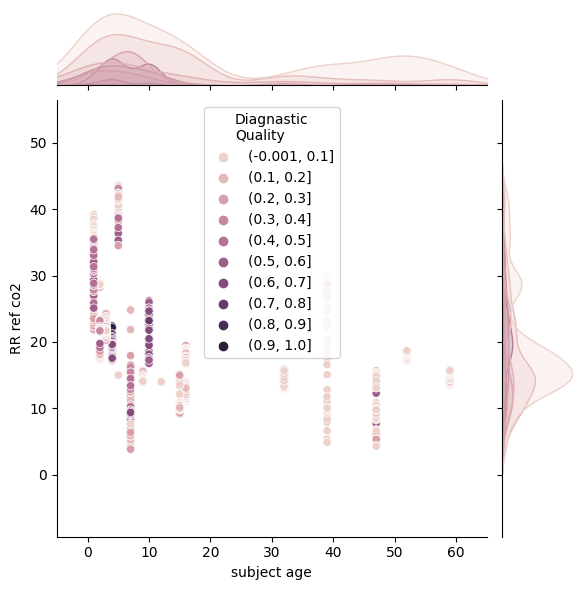

In [25]:
plot = sns.jointplot(
    data=df, x='subject age', y='RR ref co2', 
    hue='binned quality 10',
    palette=sns.cubehelix_palette(10)
    )
plot.ax_joint.legend(title='Diagnastic\nQuality')
plot.ax_joint.set_xlim(-5, 65)
# plot.ax_joint.set_ylim(0, 125)
# plot.ax_joint.plot([50,220], [25,110], 'k--', linewidth = 1)

In [28]:
# bin the quality column and create a heatmap via groupby
num_bins=25
pivot_table = df.groupby([pd.cut(df['subject age'], num_bins), pd.cut(df['RR ref co2'], num_bins)]).size().unstack(fill_value=0)
# pivot_table = pivot_table[age_bracket_order]
pivot_table = pivot_table.iloc[::-1] # flip the table so that highest quality is on top

# Create the heatmap
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d', cbar=False)
# Add an orange line between the 4th and 5th rows

# Row and column sums          
for i in range(len(pivot_table.columns)):
    ax.text(len(pivot_table.columns), i, pivot_table.sum(axis=1).values[i], va="top")

for i in range(len(pivot_table.index)):
    ax.text(i, len(pivot_table.index), pivot_table.sum(axis=0).values[i], va="center") 

plt.title('Data Counts; Age vs. RR')
plt.ylabel('Age (Months)')
plt.xlabel('RR (breaths per minute)')
plt.show()

TypeError: putmask: first argument must be an array

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

avg_age = np.array([1.5, 4.5, 7.5, 10.5, 15.5, 20.5, 30, 42, 60])
rr_lit = np.array([57,55,52,50,46,40,34,29,27]) # 90th percentile
# rr_lit = np.array([66,64,61,58,53,46,38,33,29]) # 99th percentile

# Fit logarithmic function 
def func_asmyptotic_regression(x, a, b, c):
    return a-(a-b)*np.exp(-c*x)

popt_lit, pcov = curve_fit(func_asmyptotic_regression, xdata=avg_age, ydata=rr_lit)
popt, pcov = curve_fit(func_asmyptotic_regression, xdata=df["subject age"], ydata=df["RR ref co2"])

# Plot fitted function
x = np.linspace(df["subject age"].min(), df["subject age"].max(), 100)
y = func_asmyptotic_regression(x, *popt)
y_lit = func_asmyptotic_regression(x, *popt_lit)

fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(df["subject age"], df["RR ref co2"], color="#7dbdca", alpha=0.2, edgecolors=None)
plt.plot(x, y, "#00adcf", linewidth=2, label="Kapiolani")
plt.scatter(avg_age, rr_lit, color="C1")
plt.plot(x, y_lit, color='C1', linewidth=2,label="RR, 90th percentile, Fleming 2013")
# plt.hlines(y=[40,55,70],xmin=0, xmax=df["subject age"].max(), colors="C3", linestyles='dashed')

plt.title(r"Observed Kapiolani data $\approx$ 90th percentile of RR observed in literature")
plt.xlabel("Age (months)")
plt.ylabel("Respiration Rate (breaths per min)")
plt.legend(frameon=False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# plt.grid(visible=True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# Fit logarithmic function 
def func_asmyptotic_regression(x, a, b, c):
    return a-(a-b)*np.exp(-c*x)



# Plot fitted function
x = np.linspace(avg_age.min(), avg_age.max(), 100)
y = func_asmyptotic_regression(x, *popt)

plt.scatter(df["subject age"], df["RR ref co2"], label="Kapiolani")
plt.scatter(avg_age, rr_lit, label="Literature Values")
plt.plot(x, y, 'r-', label='asmyptotic regression (literature)')

plt.xlabel("Age (months)")
plt.ylabel("Respiration Rate (breaths per min)")
plt.legend()
plt.show()

# Distribution of Single Variables

In [ ]:
plt.figure(figsize=(8,3))
plot = sns.histplot(
    data=df, 
    x='quality - template matching-pct diagnostic quality pulses',
    bins=25,
    hue='age brackets',
    hue_order=age_bracket_order,
    multiple="stack",
    palette='viridis',
    edgecolor='none',
    )
plt.xlabel('PPG Quality (1 is better)')
plt.xlim(0,1.4)
plt.legend(age_bracket_order[::-1], title="age (months)", frameon=False)
plt.xticks(ticks=[0,0.2,0.4,0.6,0.8,1])
plt.title('Relatively few data points from younger kids; high quality data exist')

In [ ]:
plt.figure(figsize=(8,3))
df['age brackets'] = pd.Categorical(df['age brackets'], age_bracket_order)

plot = sns.histplot(
    data=df, 
    x='age brackets',
    )
plt.title('Distribution of subject age is highly skewed toward older kids')
plt.xlabel('Age bracket (months)')
plt.xticks(rotation=15)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.histplot(
    data=df, 
    x='RR ref co2',
    bins=25,
    hue='binned quality 10',
    multiple="stack",
    palette='viridis',
    edgecolor='none',
    legend=True
    )
ax = plt.gca()
custom_legend = ax.legend(df['binned quality 10'].unique().sort_values(ascending=False),title="PPG Quality")
plt.xlabel('Reference RR (capnography), breaths per minute')
plt.title('Relatively few datapoints in the high RR range; all have low quality')

In [ ]:
plt.figure(figsize=(10,5))
plot = sns.histplot(
    data=df, 
    x='RR ref co2',
    bins=25,
    hue='age brackets',
    hue_order=age_bracket_order,
    multiple="stack",
    palette='viridis',
    edgecolor='none',
    legend=True
    )
ax = plt.gca()
custom_legend = ax.legend(age_bracket_order[::-1],title="Age (months)")
plt.title('All high RR data came from kids less than 3 years old')
plt.xlabel('Reference RR (capnography), breaths per minute')

In [ ]:
from scipy.stats import skew

In [ ]:
skew(df['RR ref co2'].dropna())

In [ ]:
from scipy.stats import skew

In [ ]:
temp = df['RR ref co2'].dropna()
skew(temp)

# Stats by Subjects

In [ ]:
subjects = df.dropna(subset='RR ref co2').groupby('trial').agg({'HR ref (median)': 'mean', 'RR ref co2': 'mean', 'subject age': 'mean'})

In [ ]:
subjects.describe()

In [ ]:
plot = sns.jointplot(data=subjects,x='HR ref (median)', y='RR ref co2')
plot.ax_joint.plot([50,220], [25,110], 'k--', linewidth = 1)

In [ ]:
plot = sns.histplot(data=subjects,x='subject age', kde=True)
